In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# http://www.cs.cornell.edu/~bindel/class/sjtu-summer18/lec/2018-06-27.pdf
class SquaredExponentialKernel():
    def __init__(self, scale_factor=1, length_scale=1):
        self.s = scale_factor
        self.l = length_scale

    def __call__(self, x: np.array, y: np.array) -> float:
        fn = self.s**2 * np.exp(-1 / 2 * (np.linalg.norm(x - y) / self.l)**2)
        return float(fn)

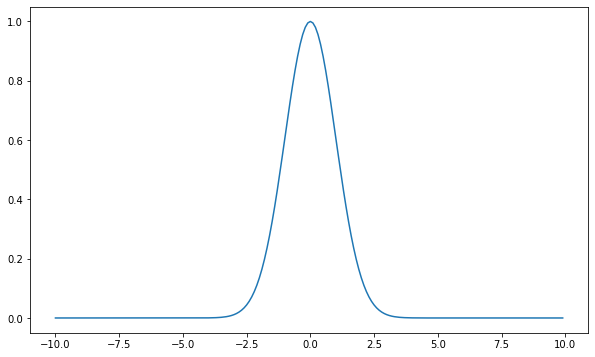

In [4]:
x_lines = np.arange(-10, 10, 0.1)
kernal = SquaredExponentialKernel(scale_factor=1, length_scale=1)
y_lines = np.array([kernal(x, 0) for x in x_lines])
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(x_lines, y_lines)

In [17]:
def calc_covariance_matrix(x1, x2, covariance_function):
    return np.array([[covariance_function(a, b) for a in x1] for b in x2])

class GaussianProcessRegressor():
    def __init__(self, data_x, data_y, noise: float=0, covariance_function=SquaredExponentialKernel()):
        self.data_x = data_x  # already observed points
        self.data_y = data_y  # output of already observed points
        self.noise = noise  
        self.cov_fn = covariance_function
        self._memory = None
        
        self.cov_matrix_of_input_data = np.linalg.inv(calc_covariance_matrix(data_x, data_y, covariance_function) + (noise + 3e-7) * np.identity(len(data_x)))
        
    def predict(self, at_values):
        k_lower_star = calc_covariance_matrix(self.data_x, at_values, self.cov_fn)
        k_lower_star2 = calc_covariance_matrix(at_values, at_values, self.cov_fn)
        
        mean_at_values = np.dot(k_lower_star, np.dot(self.data_y, self.cov_matrix_of_input_data.T).T).flatten()

        covariance_matrix = k_lower_star2 - np.dot(k_lower_star, np.dot(self.cov_matrix_of_input_data, k_lower_star.T))
        covariance_matrix = covariance_matrix + 3e-7 * np.ones(np.shape(covariance_matrix)[0])
        
        variance = np.diag(covariance_matrix)

        self._memory = {
            'mean': mean_at_values, 
            'covariance_matrix': covariance_matrix, 
            'variance': variance
        }
        
        return mean_at_values

    def plot(self, domain):
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        mean = self.predict(domain)
        std = np.sqrt(self._memory['variance'])
        
        data = []
        for i in range(1, 4):
            y_lower = mean - i * std
            y_upper = mean + i * std
            ax.fill_between(domain, y_lower, y_upper, alpha=0.5)

        ax.plot(domain, mean)
        ax.plot(self.data_x, self.data_y)
        plt.xlim([0, 5])
        plt.ylim([-1, 2])
        plt.show()

        

C:\Users\hoskinsg\AppData\Local\Temp\ipykernel_18768\2478860564.py:37: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(self._memory['variance'])


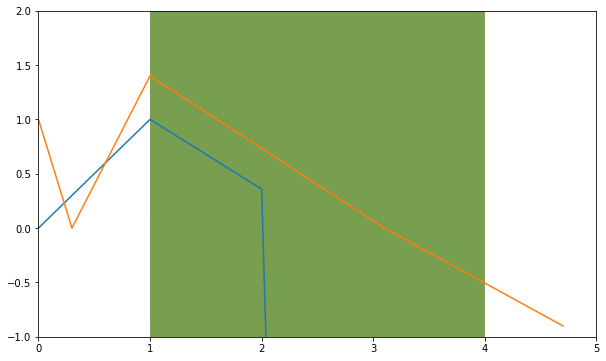

In [18]:
data_x = np.array([0, 0.3, 1, 3.1, 4.7])
data_y = np.array([1, 0, 1.4, 0, -0.9])
domain = np.arange(-1, 5)

model = GaussianProcessRegressor(data_x, data_y)
model.plot(domain)